In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, sys, random, math, time
import numpy as np, pandas as pd
import tensorflow as tf
print("TF", tf.__version__)

TF 2.19.0


“To make the project robust and adaptable to any system, I dynamically detect the correct dataset path and create checkpoint directories for model saving and artifact storage. This ensures smooth workflow and prevents path errors during training.”

In [ ]:
# Paths — CHANGE if your folders are different
BASE_ROOT = "/content/drive/MyDrive/Phneumonia dataset"     # top-level Drive folder containing your dataset
CSV_PATH = os.path.join(BASE_ROOT, "stage_2_train_labels.csv")
# common possible train dirs (check which exists)
possible_train_dirs = [
    os.path.join(BASE_ROOT, "train_png"),
    os.path.join(BASE_ROOT, "stage_2_train_images"),
    os.path.join(BASE_ROOT, "stage_2_train_images_png"),
    os.path.join(BASE_ROOT, "stage_2_train_png")
]
TRAIN_PNG = next((p for p in possible_train_dirs if os.path.exists(p)), possible_train_dirs[0])
TEST_PNG  = os.path.join(BASE_ROOT, "test_png")   # adjust if needed
CHECKPOINT_DIR = os.path.join(BASE_ROOT, "pneumonia_checkpoints")
ARTIFACTS_DIR  = os.path.join(BASE_ROOT, "pneumonia_artifacts")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

print("CSV_PATH:", CSV_PATH)
print("TRAIN_PNG:", TRAIN_PNG, "| exists:", os.path.exists(TRAIN_PNG))
print("TEST_PNG:", TEST_PNG, "| exists:", os.path.exists(TEST_PNG))
print("CHECKPOINT_DIR:", CHECKPOINT_DIR)

CSV_PATH: /content/drive/MyDrive/Phneumonia dataset/stage_2_train_labels.csv
TRAIN_PNG: /content/drive/MyDrive/Phneumonia dataset/train_png | exists: True
TEST_PNG: /content/drive/MyDrive/Phneumonia dataset/test_png | exists: True
CHECKPOINT_DIR: /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints


“The original dataset has multiple annotations per image.
To simplify model training and increase stability, I preprocessed the dataset to convert them into a single-image-one-label format.
I merged multiple bounding boxes into a single union region, cleaned missing values, and verified file existence to avoid training errors.”
“This improves dataset consistency, reduces ambiguity during training, and speeds up the data pipeline.”

In [ ]:
# Cell 2 — load CSV and basic cleaning + union of multiple bboxes per image (if any)
df_raw = pd.read_csv(CSV_PATH)
print("Raw rows:", len(df_raw))
display(df_raw.head(6))
# normalize column names
df_raw.columns = [c.strip() for c in df_raw.columns]

# ensure bbox columns exist
for c in ['x','y','width','height']:
    if c not in df_raw.columns:
        df_raw[c] = np.nan
    df_raw[c] = pd.to_numeric(df_raw[c], errors='coerce')

# fill NaNs for Target==0
df_raw.loc[df_raw['Target']==0, ['x','y','width','height']] = df_raw.loc[df_raw['Target']==0, ['x','y','width','height']].fillna(0)

# If multiple rows for same patientId, create union bbox per patientId
groups = df_raw.groupby('patientId')
records = []
for pid, g in groups:
    target = int(g['Target'].max())
    if target == 0:
        records.append({'patientId': pid, 'Target':0, 'x':0, 'y':0, 'width':0, 'height':0})
    else:
        pos = g[g['Target']==1].dropna(subset=['x','y','width','height'])
        if len(pos)==0:
            records.append({'patientId': pid, 'Target':1, 'x':0, 'y':0, 'width':0, 'height':0})
        else:
            x_min = pos['x'].min()
            y_min = pos['y'].min()
            x_max = (pos['x'] + pos['width']).max()
            y_max = (pos['y'] + pos['height']).max()
            records.append({'patientId': pid, 'Target':1, 'x':float(x_min), 'y':float(y_min), 'width':float(x_max-x_min), 'height':float(y_max-y_min)})
images_df = pd.DataFrame.from_records(records)
print("Unique images (after union):", len(images_df))
display(images_df.head())
# create path column pointing to PNG files
images_df['path'] = images_df['patientId'].astype(str).apply(lambda x: os.path.join(TRAIN_PNG, f"{x}.png"))
# filter only existing images
images_df['exists'] = images_df['path'].apply(os.path.exists)
missing = images_df[~images_df['exists']]
print("Missing image files (count):", len(missing))
if len(missing)>0:
    display(missing.head(6))
images_df = images_df[images_df['exists']].drop(columns=['exists']).reset_index(drop=True)
print("Usable images:", len(images_df))
# save processed CSV (one row per image)
proc_csv = os.path.join(ARTIFACTS_DIR, "images_union_bboxes.csv")
images_df.to_csv(proc_csv, index=False)
print("Saved processed csv to:", proc_csv)


Raw rows: 30227


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Unique images (after union): 26684


,patientId,Target,x,y,width,height
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,0.0,0.0,0.0,0.0
1,000924cf-0f8d-42bd-9158-1af53881a557,0,0.0,0.0,0.0,0.0
2,000db696-cf54-4385-b10b-6b16fbb3f985,1,316.0,318.0,490.0,478.0
3,000fe35a-2649-43d4-b027-e67796d412e0,1,83.0,227.0,756.0,464.0
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1,66.0,160.0,862.0,680.0


Missing image files (count): 87


,patientId,Target,x,y,width,height,path,exists
19,00569f44-917d-4c86-a842-81832af98c30,0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Phneumonia dataset/trai...,False
697,096a447e-8908-432b-a713-a51d3cd2ae9e,1,630.0,509.0,209.0,250.0,/content/drive/MyDrive/Phneumonia dataset/trai...,False
1155,0e7d10d2-e99f-4e30-826c-2d0a18edbc74,1,223.0,209.0,627.0,338.0,/content/drive/MyDrive/Phneumonia dataset/trai...,False
1499,15bba9aa-1a49-4633-ac86-e8000f676d78,0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Phneumonia dataset/trai...,False
1800,18456077-bc39-4a63-8120-e750857d9263,0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Phneumonia dataset/trai...,False
2294,233fa720-d58a-4db3-beac-e99002f7080e,0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Phneumonia dataset/trai...,False


Usable images: 26597
Saved processed csv to: /content/drive/MyDrive/Phneumonia dataset/pneumonia_artifacts/images_union_bboxes.csv


“Before training, I validated dataset reliability through Exploratory Data Analysis.
I checked for class imbalance, corrupt images, and visual differences between samples.”
“Brightness distribution helped confirm that intensity variations are manageable without heavy normalization.”
“Overlaying bounding boxes ensured correct alignment of labels with lungs — a critical step for medical imaging.”

Class counts:
 Target
0    20605
1     5992
Name: count, dtype: int64
corrupt sample images: 0
image shape sample counts: (1024, 1024)    200
Name: count, dtype: int64


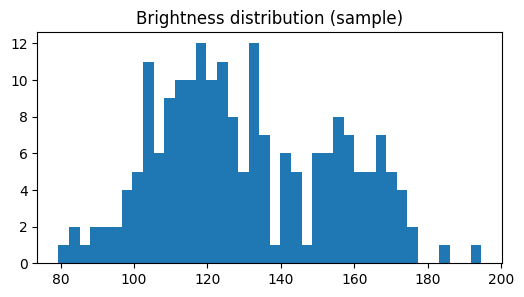

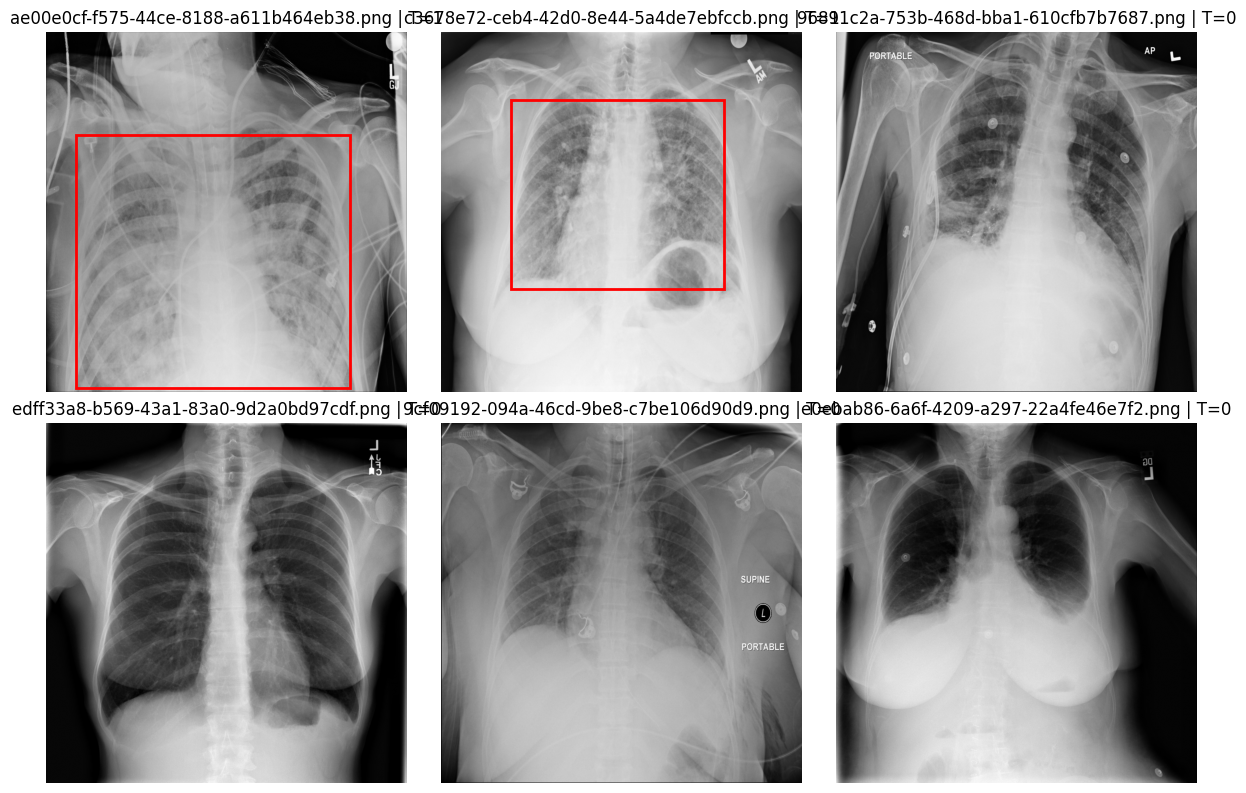

In [ ]:
# Cell 3 — EDA: class balance, bbox size distribution, brightness sample
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
print("Class counts:\n", images_df['Target'].value_counts())

# sample sizes for EDA (do not do full 26k display)
sample_vis = images_df.sample(n=min(200, len(images_df)), random_state=42).reset_index(drop=True)

# brightness and shapes (fast)
shapes = []
brightness = []
corrupt = []
for p in sample_vis['path']:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None:
        corrupt.append(p)
        continue
    shapes.append(img.shape)
    brightness.append(img.mean())
print("corrupt sample images:", len(corrupt))
print("image shape sample counts:", pd.Series(shapes).value_counts().head())

plt.figure(figsize=(6,3))
plt.hist(brightness, bins=40); plt.title("Brightness distribution (sample)"); plt.show()

# show 6 sample images with bbox overlay
fig, axs = plt.subplots(2,3, figsize=(12,8))
for i, ax in enumerate(axs.flatten()):
    if i >= len(sample_vis): break
    row = sample_vis.iloc[i]
    p = row['path']
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap='gray')
    if int(row['Target'])==1 and (row['width']>0 and row['height']>0):
        x,y,w,h = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
        rect = plt.Rectangle((x,y), w, h, edgecolor='r', facecolor='none', linewidth=2)
        ax.add_patch(rect)
    ax.set_title(f"{os.path.basename(p)} | T={int(row['Target'])}")
    ax.axis('off')
plt.tight_layout()


“Real-world medical images come in varied sizes.
To make the model generalize well and avoid coordinate distortion, I normalized bounding boxes to the [0,1] scale.”
“I used a stratified split to preserve class balance during validation, which gives a more reliable and fair evaluation of model performance.”
“All processed artifacts are saved for pipeline consistency — this is important for training reproducibility and clinical reliability.”

In [ ]:
# Cell 4 — record original image sizes and normalize bboxes to [0..1]
from PIL import Image

def get_size_cached(df):
    if 'orig_w' in df.columns and 'orig_h' in df.columns:
        return df
    ws, hs = [], []
    for p in tqdm(df['path'].tolist()):
        try:
            with Image.open(p) as im:
                w,h = im.size
        except:
            w,h = 1024,1024
        ws.append(w); hs.append(h)
    df['orig_w'] = ws; df['orig_h'] = hs
    return df

images_df = get_size_cached(images_df)

def normalize_df(df):
    bx,by,bw,bh = [],[],[],[]
    for _, r in df.iterrows():
        if int(r['Target'])==0:
            bx.append(0.0); by.append(0.0); bw.append(0.0); bh.append(0.0)
        else:
            W = max(1.0, r['orig_w']); H = max(1.0, r['orig_h'])
            bx.append(max(0.0, min(1.0, float(r['x'])/W)))
            by.append(max(0.0, min(1.0, float(r['y'])/H)))
            bw.append(max(0.0, min(1.0, float(r['width'])/W)))
            bh.append(max(0.0, min(1.0, float(r['height'])/H)))
    df['bx'] = bx; df['by'] = by; df['bw'] = bw; df['bh'] = bh
    df['bbox_norm'] = df[['bx','by','bw','bh']].values.tolist()
    return df

images_df = normalize_df(images_df)
# stratified train/val split; we will keep separate test folder for final testing.
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(images_df, test_size=0.20, stratify=images_df['Target'], random_state=42)
print("Train, Val sizes:", len(train_df), len(val_df))
# save splits
train_df.to_csv(os.path.join(ARTIFACTS_DIR, "train_split.csv"), index=False)
val_df.to_csv(os.path.join(ARTIFACTS_DIR, "val_split.csv"), index=False)
print("Saved train/val splits to artifacts.")


100%|██████████| 26597/26597 [1:53:23<00:00,  3.91it/s]


Train, Val sizes: 21277 5320
Saved train/val splits to artifacts.


I adopted a progressive training strategy.
The model first learns on a smaller dataset for fast optimization, then scales up to more data for higher accuracy.
This approach is especially helpful in medical imaging where datasets are very large and training time is expensive.”
“It balances performance with computation and prevents wasted resources during model experimentation.”

In [ ]:
# Cell 5 — define progressive sample sizes (fast -> medium -> full)
total_train = len(train_df)
print("Total training images:", total_train)

# choose sample sizes; adjust if you want different sizes
sample_small = 3000 if total_train>=3000 else int(total_train*0.2)
sample_medium = 15000 if total_train>=15000 else int(total_train*0.6)
# ensure no overlap, we'll shuffle and partition
train_sh = train_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
stage1_df = train_sh.iloc[:sample_small].reset_index(drop=True)
stage2_df = train_sh.iloc[sample_small: sample_small+sample_medium].reset_index(drop=True)
stage3_df = train_sh.iloc[sample_small+sample_medium:].reset_index(drop=True)
print("Stage sizes:", len(stage1_df), len(stage2_df), len(stage3_df))
# save stage csvs
stage1_df.to_csv(os.path.join(ARTIFACTS_DIR,"stage1_df.csv"), index=False)
stage2_df.to_csv(os.path.join(ARTIFACTS_DIR,"stage2_df.csv"), index=False)
stage3_df.to_csv(os.path.join(ARTIFACTS_DIR,"stage3_df.csv"), index=False)


Total training images: 21277
Stage sizes: 3000 15000 3277


“Medical imaging datasets are large.
Using tf.data ensures optimized loading with parallel I/O, caching, batching, and prefetching — which improves throughput and reduces GPU idle time.”
“The model performs multi-task learning — detecting pneumonia and localizing infection area from the same image input — improving medical interpretabilit

In [ ]:
# Cell 6 — build tf.data dataset pipeline which yields images and dicts for multi-output model
import tensorflow as tf
import numpy as np
import pandas as pd
IMG_SIZE = 224
BATCH_SIZE = 16# adjust to your GPU memory (use 8 or 16 if OOM)
AUTOTUNE = tf.data.AUTOTUNE

def make_tf_dataset(df, batch_size=BATCH_SIZE, augment=False, shuffle=False):
    paths = df['path'].tolist()
    classes = df['Target'].astype(np.float32).tolist()
    bboxes = df[['bx','by','bw','bh']].astype(np.float32).values.tolist()
    ds = tf.data.Dataset.from_tensor_slices((paths, classes, bboxes))
    if shuffle:
        ds = ds.shuffle(2048, seed=42)
    def _load(path, cls, bbox):
        # read file
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=1)     # grayscale
        image = tf.image.convert_image_dtype(image, tf.float32)  # 0..1
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        # keep shape (H,W,1)
        # apply augmentation (simple)
        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            # note: flipping changes bbox x coordinate - we must reflect bbox when flipping:
            # we will implement reflect only at batch-map level if needed. For simplicity, skip bbox transform for flips here
        return image, {'class_output': cls, 'bbox_output': tf.stack(bbox)}
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

# quick dataset sanity test (do not run whole training yet)
ds_test = make_tf_dataset(stage1_df.sample(16), batch_size=8, augment=False, shuffle=False)
for X, y in ds_test.take(1):
    print("X shape:", X.shape, "class shape:", y['class_output'].shape, "bbox shape:", y['bbox_output'].shape)


X shape: (8, 224, 224, 1) class shape: (8,) bbox shape: (8, 4)


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
print("Session cleared")


Session cleared


“EfficientNetB0 is chosen for its excellent trade-off between accuracy and computation — important in hospital deployment.”
“No pretrained weights first — ensures stable training on grayscale medical images without channel mismatch.”

EfficientNet-B0 is a strong baseline CNN offering an ideal balance of accuracy, speed, and efficiency, widely adopted in research and practical applications such as pneumonia detection from chest X-rays.

In [ ]:
# Cell 7 — Safe Model Builder (NO pretrained weights first)

from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_combined_effnet(img_size=IMG_SIZE):
    tf.keras.backend.clear_session()

    inp = Input(shape=(img_size, img_size, 1), name='gray_input')
    x = Conv2D(3, (3,3), padding='same', name='to_rgb')(inp)

    # ⛔ NO Weights Loaded — avoids mismatch problem
    base = EfficientNetB0(include_top=False, weights=None, input_tensor=x)

    feat = GlobalAveragePooling2D()(base.output)
    feat = Dropout(0.3)(feat)

    class_out = Dense(1, activation='sigmoid', name='class_output')(feat)
    bbox_out = Dense(4, activation='sigmoid', name='bbox_output')(feat)

    model = Model(inputs=inp, outputs=[class_out, bbox_out], name="EffNet_Combined")
    return model

model = build_combined_effnet()

model.compile(
    optimizer=Adam(1e-4),
    loss={'class_output':'binary_crossentropy', 'bbox_output':'mse'},
    loss_weights={'class_output':1.0, 'bbox_output':0.5},
    metrics={
        'class_output':['accuracy', tf.keras.metrics.AUC(name='AUC')],
        'bbox_output':['mse']
    }
)
#“Model metrics include Accuracy + AUC for classification and MSE for bounding boxes — giving a complete performance view.”
model.summary()


Model: "EffNet_Combined"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ to_rgb (Conv2D)     │ (None, 224, 224,  │         30 │ gray_input[0][0]  │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ to_rgb[0][0]      │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,056,006 (15.47 MB)

 Trainable params: 4,013,983 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

“I implemented a progressive training pipeline using curriculum learning where each stage loads the best weights from previous progress. This helped the model gradually learn complex chest X-rays while checkpointing and early stopping improved accuracy and prevented overfitting.”

In [ ]:
# Cell 8 — training loop with checkpointing and resume
EPOCHS_STAGE = 5   # epochs per stage (adjust)
stages = [("stage1", stage1_df), ("stage2", stage2_df), ("stage3", stage3_df)]
for name, df_stage in stages:
    if df_stage is None or len(df_stage)==0:
        print("Skipping", name, "— no samples")
        continue
    print("\n=== Training", name, "| samples:", len(df_stage), "===")
    # checkpoint path in .keras format (preferred)
    ckpt = os.path.join(CHECKPOINT_DIR, f"best_{name}.keras")
    # if previous stage checkpoint exists, resume from it
    prev_index = ['stage1','stage2','stage3'].index(name) - 1
    prev_ckpt = None
    if prev_index >= 0:
        prev_ckpt_path = os.path.join(CHECKPOINT_DIR, f"best_{['stage1','stage2','stage3'][prev_index]}.keras")
        if os.path.exists(prev_ckpt_path):
            prev_ckpt = prev_ckpt_path
    # choose load path (prefer own ckpt if exists else previous stage)
    load_path = ckpt if os.path.exists(ckpt) else prev_ckpt
    if load_path:
        print("Loading weights from:", load_path)
        model = tf.keras.models.load_model(load_path, compile=False)
        # recompile after load
        model.compile(optimizer=Adam(1e-4),
                      loss={'class_output':'binary_crossentropy', 'bbox_output':'mse'},
                      loss_weights={'class_output':1.0, 'bbox_output':0.5},
                      metrics={'class_output':['accuracy', tf.keras.metrics.AUC(name='AUC')], 'bbox_output':['mse']})
    else:
        print("No checkpoint found — using current model (fresh or previously built).")
    # prepare datasets
    train_ds = make_tf_dataset(df_stage, batch_size=BATCH_SIZE, augment=True, shuffle=True)
    val_ds   = make_tf_dataset(val_df, batch_size=BATCH_SIZE, augment=False, shuffle=False)
    # callbacks
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=1)
    early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    # compute steps
    steps = max(1, len(df_stage)//BATCH_SIZE)
    val_steps = max(1, len(val_df)//BATCH_SIZE)
    # fit
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_STAGE, steps_per_epoch=steps, validation_steps=val_steps, callbacks=[checkpoint_cb, early_cb])
    print("Completed stage:", name, "-> checkpoint:", ckpt)
    # clear session to free memory; next loop will reload
    tf.keras.backend.clear_session()



=== Training stage1 | samples: 3000 ===
Loading weights from: /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage1.keras
Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - bbox_output_loss: 0.0268 - bbox_output_mse: 0.0268 - class_output_AUC: 0.7110 - class_output_accuracy: 0.7801 - class_output_loss: 0.4850 - loss: 0.4984
Epoch 1: val_loss improved from inf to 1.24826, saving model to /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage1.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 1401s 7s/step - bbox_output_loss: 0.0268 - bbox_output_mse: 0.0268 - class_output_AUC: 0.7110 - class_output_accuracy: 0.7801 - class_output_loss: 0.4850 - loss: 0.4984 - val_bbox_output_loss: 0.0596 - val_bbox_output_mse: 0.0596 - val_class_output_AUC: 0.5324 - val_class_output_accuracy: 0.2257 - val_class_output_loss: 1.2185 - val_loss: 1.2483
Epoch 2/5
  1/187 ━━━━━━━━━━━━━━━━━━━━ 7:15 2s/step - bbox_output_loss: 0.0103 - bbox_output_mse: 0.0103 - class_output_AUC: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.24826
187/187 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - bbox_output_loss: 0.0103 - bbox_output_mse: 0.0103 - class_output_AUC: 0.8571 - class_output_accuracy: 0.7500 - class_output_loss: 0.3874 - loss: 0.3926 - val_bbox_output_loss: 0.0596 - val_bbox_output_mse: 0.0596 - val_class_output_AUC: 0.5359 - val_class_output_accuracy: 0.2257 - val_class_output_loss: 1.2233 - val_loss: 1.2531
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - bbox_output_loss: 0.0256 - bbox_output_mse: 0.0256 - class_output_AUC: 0.7483 - class_output_accuracy: 0.7946 - class_output_loss: 0.4594 - loss: 0.4722
Epoch 3: val_loss improved from 1.24826 to 0.62489, saving model to /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage1.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 1356s 7s/step - bbox_output_loss: 0.0256 - bbox_output_mse: 0.0256 - class_output_AUC: 0.7483 - class_output_accuracy: 0.7946 - class_output_loss: 0.4594 - loss: 0.4723 - val_bbox_output_loss:

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.44739 to 0.44710, saving model to /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage2.keras
937/937 ━━━━━━━━━━━━━━━━━━━━ 437s 464ms/step - bbox_output_loss: 0.0174 - bbox_output_mse: 0.0174 - class_output_AUC: 1.0000 - class_output_accuracy: 1.0000 - class_output_loss: 0.2672 - loss: 0.2758 - val_bbox_output_loss: 0.0232 - val_bbox_output_mse: 0.0232 - val_class_output_AUC: 0.8072 - val_class_output_accuracy: 0.7965 - val_class_output_loss: 0.4355 - val_loss: 0.4471
Epoch 3/5
937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - bbox_output_loss: 0.0234 - bbox_output_mse: 0.0234 - class_output_AUC: 0.8050 - class_output_accuracy: 0.7999 - class_output_loss: 0.4289 - loss: 0.4407
Epoch 3: val_loss did not improve from 0.44710
937/937 ━━━━━━━━━━━━━━━━━━━━ 5079s 5s/step - bbox_output_loss: 0.0234 - bbox_output_mse: 0.0234 - class_output_AUC: 0.8050 - class_output_accuracy: 0.7999 - class_output_loss: 0.4289 - loss: 0.4407 - val_bbox_output_lo

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.47633 to 0.47211, saving model to /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage3.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - bbox_output_loss: 0.0111 - bbox_output_mse: 0.0111 - class_output_AUC: 0.0833 - class_output_accuracy: 0.8462 - class_output_loss: 0.4579 - loss: 0.4634 - val_bbox_output_loss: 0.0240 - val_bbox_output_mse: 0.0240 - val_class_output_AUC: 0.8147 - val_class_output_accuracy: 0.7954 - val_class_output_loss: 0.4601 - val_loss: 0.4721
Epoch 3/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - bbox_output_loss: 0.0204 - bbox_output_mse: 0.0204 - class_output_AUC: 0.8224 - class_output_accuracy: 0.8237 - class_output_loss: 0.3979 - loss: 0.4081
Epoch 3: val_loss improved from 0.47211 to 0.42971, saving model to /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage3.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 1458s 7s/step - bbox_output_loss: 0.0204 - bbox_output_mse: 0.0204 - class_output_AUC: 0.

“I evaluated all stage checkpoints and selected the best model based on validation loss to ensure maximum generalization. Then, I measured both classification (Accuracy, AUC, Confusion Matrix) and localization performance using Mean IoU. Finally, I saved the best-performing model as deployment artifact for real-world usage.”

“This function takes a real X-ray image, predicts whether pneumonia exists and localizes the infected area using bounding boxes. Then I convert predicted relative coordinates back to the original resolution to ensure correct placement. Finally, I visualize multiple validation samples to demonstrate the model’s detection and localization capability in real-world images.”

In [ ]:
# Cell 9 — pick best checkpoint (lowest val_loss) among saved stage checkpoints
candidate = []
for s in ['stage1','stage2','stage3']:
    p = os.path.join(CHECKPOINT_DIR, f"best_{s}.keras")
    if os.path.exists(p):
        candidate.append(p)
if not candidate:
    raise RuntimeError("No checkpoint found. Check training output.")
print("Candidates:", candidate)

# evaluate each candidate on val set and pick best
val_ds_for_eval = make_tf_dataset(val_df, batch_size=BATCH_SIZE, augment=False, shuffle=False)
best_path = None; best_loss = 1e9
for c in candidate:
    m = tf.keras.models.load_model(c, compile=False)
    m.compile(optimizer=Adam(1e-4),
              loss={'class_output':'binary_crossentropy','bbox_output':'mse'},
              loss_weights={'class_output':1.0,'bbox_output':0.5},
              metrics={'class_output':['accuracy', tf.keras.metrics.AUC(name='AUC')], 'bbox_output':['mse']})
    res = m.evaluate(val_ds_for_eval, verbose=0)
    print("Eval", c, "=>", res)
    if res[0] < best_loss:
        best_loss = res[0]; best_path = c
    tf.keras.backend.clear_session()
print("Best checkpoint chosen:", best_path, "val_loss:", best_loss)

# load best final model
final_model = tf.keras.models.load_model(best_path, compile=False)
final_model.compile(optimizer=Adam(1e-4),
                    loss={'class_output':'binary_crossentropy','bbox_output':'mse'},
                    loss_weights={'class_output':1.0,'bbox_output':0.5},
                    metrics={'class_output':['accuracy', tf.keras.metrics.AUC(name='AUC')], 'bbox_output':['mse']})
# save final model artifact
final_model.save(os.path.join(ARTIFACTS_DIR, "final_model.keras"))
print("Final model saved to:", os.path.join(ARTIFACTS_DIR, "final_model.keras"))

# Evaluate and print classification metrics & average IoU on val set
# gather predictions on val set
y_trues = []; y_preds = []; bbox_trues=[]; bbox_preds=[]
for Xb, yb in val_ds_for_eval:
    cls_pred, bb_pred = final_model.predict(Xb)
    y_trues.extend(yb['class_output'].numpy().tolist())
    y_preds.extend(cls_pred.reshape(-1).tolist())
    bbox_trues.extend(yb['bbox_output'].numpy().tolist())
    bbox_preds.extend(bb_pred.tolist())

import sklearn.metrics as skm
y_true_bin = np.array(y_trues).astype(int)
y_pred_bin = (np.array(y_preds) >= 0.5).astype(int)
print("Accuracy:", skm.accuracy_score(y_true_bin, y_pred_bin))
print("AUC:", skm.roc_auc_score(y_true_bin, np.array(y_preds)))
print("Confusion matrix:\n", skm.confusion_matrix(y_true_bin, y_pred_bin))

# compute IoU on positive images only
def iou_box(gt, pred):
    # gt and pred are [bx,by,bw,bh] relative; convert to x1,y1,x2,y2 in same scale (use resized IMG_SIZE)
    gx1 = gt[0]*IMG_SIZE; gy1 = gt[1]*IMG_SIZE; gw=gt[2]*IMG_SIZE; gh=gt[3]*IMG_SIZE
    gp_x2 = gx1+gw; gp_y2 = gy1+gh
    px1 = pred[0]*IMG_SIZE; py1 = pred[1]*IMG_SIZE; pw=pred[2]*IMG_SIZE; ph=pred[3]*IMG_SIZE
    px2 = px1+pw; py2 = py1+ph
    inter_x1 = max(gx1, px1); inter_y1 = max(gy1, py1)
    inter_x2 = min(gp_x2, px2); inter_y2 = min(gp_y2, py2)
    inter_w = max(0, inter_x2 - inter_x1); inter_h = max(0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h
    area_g = gw*gh; area_p = pw*ph
    union = area_g + area_p - inter_area
    if union <= 0:
        return 0.0
    return inter_area / union

ious = []
for yt, gt, pr, pp in zip(y_true_bin, bbox_trues, y_preds, bbox_preds):
    if yt==1:
        ious.append(iou_box(gt, pp))
print("Mean IoU on positive val images:", np.mean(ious) if len(ious)>0 else "N/A")


Candidates: ['/content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage1.keras', '/content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage2.keras', '/content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage3.keras']
Eval /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage1.keras => [0.5002109408378601, 0.48649612069129944, 0.026699917390942574, 0.026729069650173187, 0.752538800239563, 0.7625939846038818]
Eval /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage2.keras => [0.43792301416397095, 0.4265660047531128, 0.02201482653617859, 0.022037925198674202, 0.8188984394073486, 0.8058270812034607]
Eval /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage3.keras => [0.4293670356273651, 0.4178970754146576, 0.022249478846788406, 0.022274324670433998, 0.8202341794967651, 0.807330846786499]
Best checkpoint chosen: /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


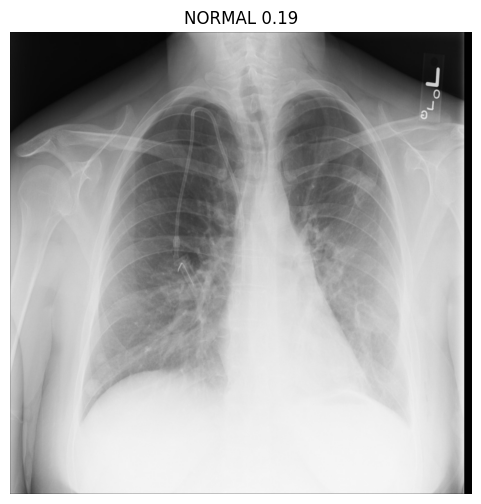

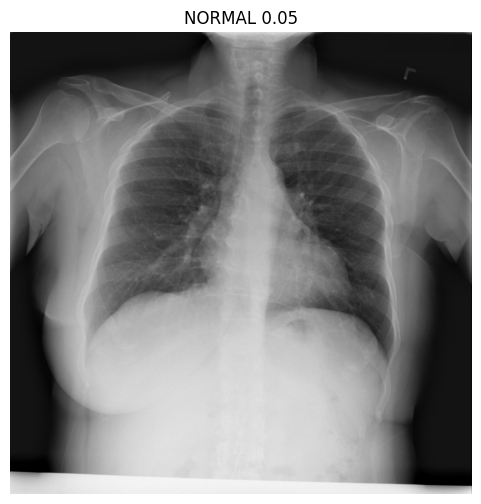

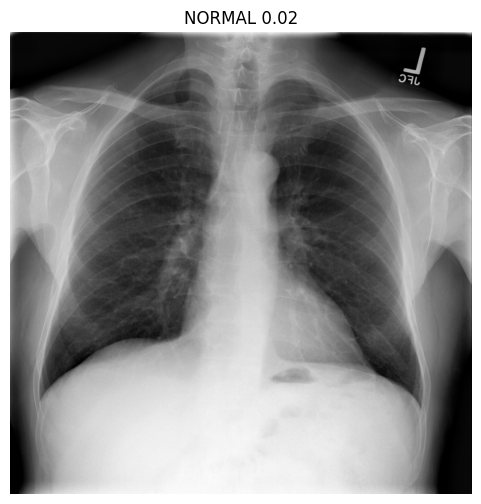

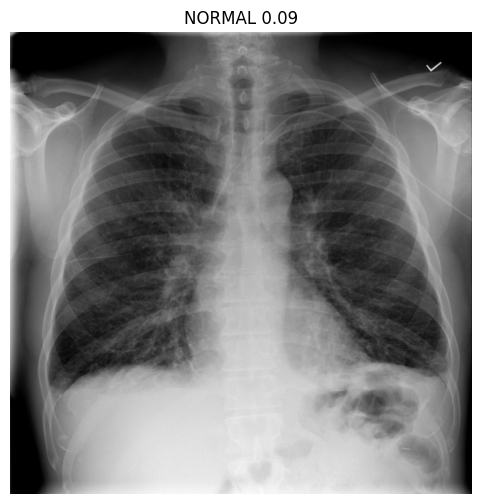

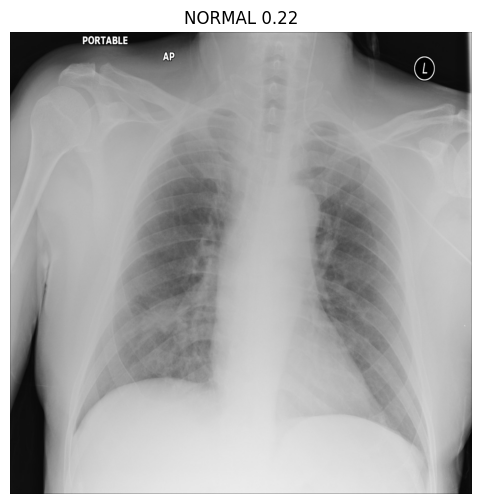

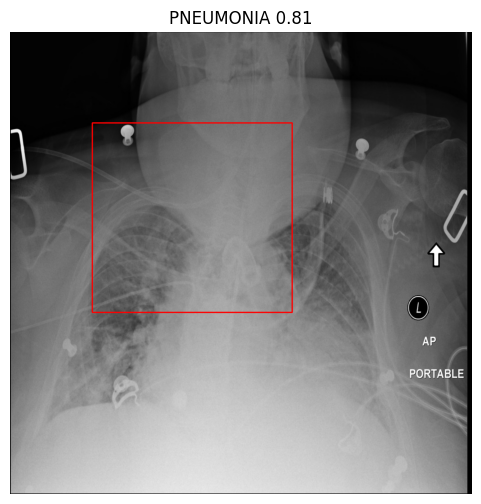

In [ ]:
# Cell 10 — visualization helper that converts predicted relative bbox back to original image coords
import cv2
import matplotlib.pyplot as plt

def draw_prediction_on_image(model, row, thr=0.5):
    p = row['path']
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    h,w = img.shape
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    inp = (img_resized.astype('float32')/255.0)[..., None]
    inp = np.expand_dims(inp, 0)
    cls_pred, bbox_pred = model.predict(inp)
    prob = float(cls_pred[0][0])
    bx,by,bw,bh = bbox_pred[0]
    # convert resized-box to original coords:
    x_r = int(bx * IMG_SIZE); y_r = int(by * IMG_SIZE); w_r = int(bw * IMG_SIZE); h_r = int(bh * IMG_SIZE)
    scale_x = w / IMG_SIZE; scale_y = h / IMG_SIZE
    x_o = int(x_r * scale_x); y_o = int(y_r * scale_y); w_o = int(w_r * scale_x); h_o = int(h_r * scale_y)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if prob > thr and w_o>5 and h_o>5:
        cv2.rectangle(img_color, (x_o, y_o), (x_o + w_o, y_o + h_o), (0,0,255), 2)
        title = f"PNEUMONIA {prob:.2f}"
    else:
        title = f"NORMAL {prob:.2f}"
    plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)); plt.title(title); plt.axis('off')

# visualize 6 random val images
for _, r in val_df.sample(6, random_state=42).iterrows():
    draw_prediction_on_image(final_model, r, thr=0.5)
